In [1]:
import tensorflow as tf

In [2]:
from PIL.Image import open
from numpy import array, float32, reshape

In [3]:
from watermarking import training

In [4]:
from re import sub, search
from os import listdir
from numpy import expand_dims, uint8, mean, asarray, flip
from watermarking import embedding, process, extraction, cnn

<h3>Change Watermark to One-Hot</h3>

In [5]:
def WM_to_one_hot(wm):
    one_hot = []
    for row in wm:
        new_row = []
        for _px in row:
            new_row.append(
                [0, 1] if _px == 0 else [1, 0]
            )
        one_hot.append(new_row)
    return array(one_hot)

def WMs_to_one_hot(wms):
    one_hot_wms = []
    for wm in wms:
        one_hot_wms.append(WM_to_one_hot(wm))
    return array(one_hot_wms)

In [6]:
train = training.Training()

initializing


In [7]:
attacked_watermarks = WMs_to_one_hot(
    train.normalize_watermark(
        train.apply_transformations(
            open("Watermark.tiff"), iswatermark=True
        )
    )
)


In [8]:
test = train.normalize_watermark(
    train.apply_transformations(
        open("Watermark.tiff"), iswatermark=True
    )
)

In [9]:
watermark = open("Watermark.tiff")

<h3>Load Training Images</h3>

In [10]:
def create_label(wms, total_img):
    label = []
    attack_i = 0
    for i in range(total_img):
        label.append(wms[0])
        attack_i += 1
        if attack_i == 24:
            attack_i = 0
    return array(label)

In [11]:
def create_dataset(prepath, processing_path):
    images_filename = listdir(prepath)
    datasets = []
    for filename in images_filename:
        image = open(prepath + "/" + filename)
        full_path = processing_path + "/" + sub(
            search(".tif+$", filename).group(), "", filename
        )
        embedding.Embedding().embed_watermark(
            process.Process.pil_to_open_cv(
                image
            ),
            array(watermark, dtype=uint8),
            full_path
        )
        image = open(full_path + ".tif")
        datasets.extend(
            expand_dims(
                train.normalize_embedding_maps(
                    train.get_embedding_maps(                   
                        train.apply_transformations(image),
                        extraction.Extraction().extract_key_from_pil_image(image)
                    )
                ), axis=3
            )
        )
    return datasets

In [12]:
train_imgs = create_dataset(train.PRE_TRAINING_PATH, train.TRAINING_PATH)

total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24


In [13]:
test_imgs = create_dataset(
    'static/test',
    'static/testing'
)

total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24
total:  24


In [14]:
train_imgs = array(train_imgs)
test_imgs = array(test_imgs)

In [15]:
train_imgs.shape

(960, 64, 64, 1)

In [16]:
test_imgs.shape

(360, 64, 64, 1)

In [17]:
train_label = create_label(attacked_watermarks, train_imgs.shape[0])
test_label = create_label(attacked_watermarks, test_imgs.shape[0])

<h3>Model</h3>

In [18]:
model = tf.keras.Sequential([
    # encoder
    tf.keras.layers.Conv2D(
        8, 7, input_shape=(64, 64, 1), activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
    tf.keras.layers.Conv2D(
        8, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(),
    # decoder
    tf.keras.layers.UpSampling2D(),
    tf.keras.layers.Conv2D(
        8, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
    tf.keras.layers.Conv2D(
        8, 7, activation='relu', padding = 'same', kernel_initializer = 'random_normal', use_bias=False
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        2, 7, activation = 'softmax', padding= 'same', kernel_initializer = 'random_normal', use_bias=False
    )
])

model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 8)         392       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         3136      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 8)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         3136      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 8)         3

In [20]:
%%time
history = model.fit(
    train_imgs,
    train_label,
    validation_data=(test_imgs, test_label),
    epochs=100,
    batch_size=64,
    verbose=0
)

Wall time: 38min 46s


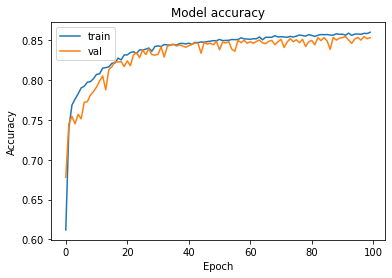

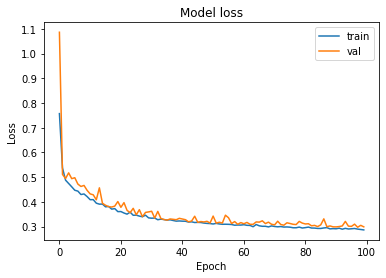

<function matplotlib.pyplot.close(fig=None)>

In [21]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('static/layer-channel-test/88-88batch-64-acc2-0.1.png')
plt.show()
plt.close()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.savefig('static/layer-channel-test/88-88batch-64-loss2-0.1.png')
plt.show()
plt.close

In [22]:
image = open("static/training/bird.tif")

In [23]:
ext = extraction.Extraction()

In [24]:
key = ext.extract_key_from_pil_image(image)

In [25]:
em = expand_dims(ext.get_embedding_map(process.Process.pil_to_open_cv(image), key), axis=2)

In [26]:
%%time
result = model.predict(expand_dims(em, axis=0))

Wall time: 201 ms


In [27]:
classified = []
for row in result[0]:
    new_row = []
    for _px in row:
        new_row.append(
            255 if _px[0] > _px[1] else 0
        )
    classified.append(new_row)

In [28]:
from matplotlib.pyplot import imshow

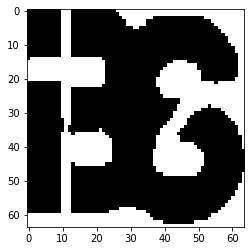

In [29]:
imshow(classified, cmap='gray')

In [30]:
extraction.Extraction.normalized_correlation_coef(classified, watermark)

0.9683892396583422

NC
88:11 = 0.9119992164191522, 26 min, 195ms, 4,103 params <br>
88:88 = 0.9683892396583422, 38min 46s, 201ms, 10,648 params

In [31]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [32]:
layer_dict

{'conv2d': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1d0642891c0>,
 'conv2d_1': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1d064a0e9d0>,
 'batch_normalization': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x1d064a0ee80>,
 'max_pooling2d': <tensorflow.python.keras.layers.pooling.MaxPooling2D at 0x1d063cb5220>,
 'up_sampling2d': <tensorflow.python.keras.layers.convolutional.UpSampling2D at 0x1d063cb5490>,
 'conv2d_2': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1d063cb5670>,
 'conv2d_3': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1d063cb5b20>,
 'batch_normalization_1': <tensorflow.python.keras.layers.normalization_v2.BatchNormalization at 0x1d063cb5fa0>,
 'conv2d_4': <tensorflow.python.keras.layers.convolutional.Conv2D at 0x1d063cbf3a0>}

<h3>Change Weight Shape</h3>

In [106]:
weight = layer_dict['conv2d_1'].weights

param_dict = {
    'dec0-gamma': [weight[0].numpy().tolist()],
    'dec0-beta': [weight[1].numpy().tolist()],
    'dec0-average': [weight[2].numpy().tolist()],
    'dec0-variance': [weight[3].numpy().tolist()],
}

In [107]:
weight = weight[0].numpy()

In [108]:
weight.shape

(7, 7, 8, 8)

In [109]:
def reverse_shape(weight):
    """7718 -> 8177"""
    ch_number = weight.shape[3]
    input_number = weight.shape[2]
    new_weight = []
    for i in range(ch_number):
        new_channel = []
        for j in range(input_number):
            new_input = []
            for row in weight:
                new_row = []
                for _px in row:
                    new_row.append(_px[j][i])
                new_input.append(new_row)
            new_channel.append(new_input)
        new_weight.append(new_channel)
    return new_weight

In [110]:
def fix_reverse_shape(weight):
    """877 -> 778"""
    (i_number, w, h) = weight.shape
    new_weight = np.zeros((w, h, i_number))
    for i in range(i_number):
        for j in range(w):
            for k in range(h):
                new_weight[j, k, i] = weight[i, j, k]
    return new_weight

In [111]:
reversed_weight = array(reverse_shape(weight))

In [112]:
reversed_weight.shape

(8, 8, 7, 7)

In [113]:
def create_param_dict(weight, prefix):
    param = {}
    for i, channel in enumerate(weight):
        for j, matrix in enumerate(channel):
            param[prefix + '-' + str(i) + '-' + str(j)] = matrix
    return param

In [114]:
def create_softmax_param_dict(weight):
    params = ['fg', 'bg']
    param_dict = {}
    for i, param in enumerate(params):
        for j, kernel in enumerate(weight[i]):
            param_dict['softmax-' + param + str(j)] = kernel
    return param_dict

In [115]:
param_dict = create_param_dict(reversed_weight, 'enc0-1')

param_dict = create_softmax_param_dict(reversed_weight)

In [116]:
cnn.CNN.store_param(param_dict)

<h3>Get Visualization Model</h3>

In [ ]:
outputs = [layer.output for layer in model.layers[1:]]

In [ ]:
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = outputs)

In [ ]:
feature_maps = visualization_model.predict(array([train_imgs[0]]))

In [ ]:
imshow(array(train_imgs[0]).reshape((64, 64)))

In [ ]:
array(train_imgs[0]).reshape((64, 64))

In [ ]:
def reverse_shape_fm(feature_map):
    ch_number = feature_map.shape[2]
    new_fm = []
    for i in range(ch_number):
        new_channel = []
        for row in feature_map:
            new_row = []
            for _px in row:
                new_row.append(_px[i])
            new_channel.append(new_row)
        new_fm.append(new_channel)
    return new_fm

In [ ]:
array(feature_maps[6]).shape

In [ ]:
len(feature_maps)

In [ ]:
reversed_fm = reverse_shape_fm(feature_maps[6][0])

In [ ]:
from matplotlib.pyplot import figure

In [ ]:
array(reversed_fm).shape

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
fig = figure(figsize=(50, 50))
for i in range(len(reversed_fm)):
    sub = fig.add_subplot(2, 16, i + 1)
    sub.imshow(reversed_fm[i], interpolation='nearest')

In [ ]:
a = tf.keras.layers.Conv2D(
    8, 7, input_shape=(64, 64, 1), padding = 'same', kernel_initializer=tes, use_bias=False
)(array([train_imgs[0]]))

In [ ]:
def tes(shape, dtype=None):
    w = layer_dict['conv2d'].weights[0].numpy()
    print(w.shape)
#     w[tuple(map(lambda x: int(np.floor(x/2)), w.shape))]=1
    return w

In [ ]:
a = a.numpy()

In [ ]:
imshow(reverse_shape_fm(a[0])[3])

In [ ]:
a.numpy().shape

In [ ]:
tf.keras.layers.UpSampling2D()(a.numpy())

In [ ]:
a.shape